<a href="https://colab.research.google.com/github/Shreyasii11/Online_book_store/blob/main/Final_Try_HOG_and_SIFT_with_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [ ]:
import cv2
import numpy as np
import os
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from skimage.feature import hog
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
import joblib
from sklearn.svm import LinearSVC

In [ ]:
# Load the image dataset
data = []
labels = []
for folder_name in ['Oranges', 'Non-Oranges']:
    folder_path = f'/content/drive/My Drive/Fruit_Dataset/{folder_name}/'
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (64, 64))
        data.append(img_resized)
        labels.append(1 if folder_name == 'Oranges' else 0)

In [ ]:
# Extract HOG features from the image dataset
hog_features = []
for img in data:
    fd = hog(img, orientations=6, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=False)
    hog_features.append(fd)
hog_features = np.array(hog_features)


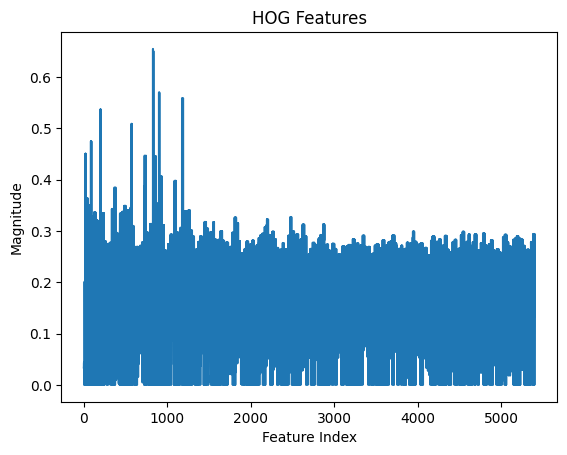

In [ ]:
# Visualize the HOG features of an image
sample_hog = hog_features[1]  # Choose any HOG feature vector
plt.plot(sample_hog)
plt.title('HOG Features')
plt.xlabel('Feature Index')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
# Extract SIFT features from the image dataset
sift_features = []
for img in data:
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    if des is None:
        des = np.zeros((1, 128))
    sift_features.append(des)
sift_features = np.array(sift_features)

<ipython-input-8-b851d14de1c8>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_features = np.array(sift_features)


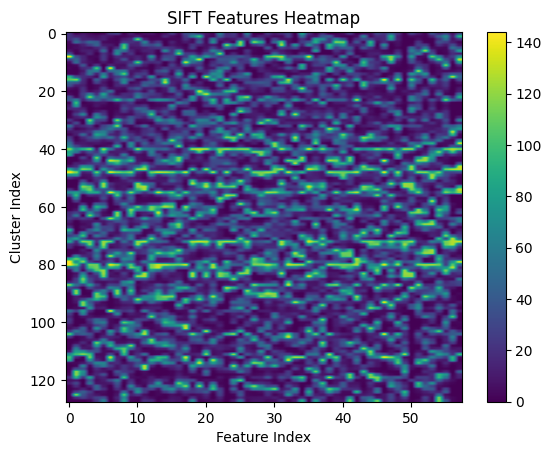

In [ ]:
# Visualize the SIFT features of an image
sample_sift = sift_features[0]  # Choose any SIFT feature vector

# Reshape the SIFT features to create a 2D heatmap
num_clusters = 128
heatmap = sample_sift.reshape(-1, num_clusters).T

plt.imshow(heatmap, cmap='viridis', aspect='auto')
plt.title('SIFT Features Heatmap')
plt.xlabel('Feature Index')
plt.ylabel('Cluster Index')
plt.colorbar()
plt.show()


In [ ]:
# Concatenate the HOG and SIFT feature vectors
sift_features = np.concatenate(sift_features, axis=0)
scaler = StandardScaler().fit(sift_features)
sift_features = scaler.transform(sift_features)
kmeans = KMeans(n_clusters=128, random_state=0).fit(sift_features)
sift_features = np.zeros((len(data), 128))
for i in range(len(data)):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(data[i], None)
    if des is None:
        des = np.zeros((1, 128))
    sift_features[i] = np.bincount(kmeans.predict(scaler.transform(des)), minlength=128)

concatenated_features = np.concatenate((hog_features, sift_features), axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


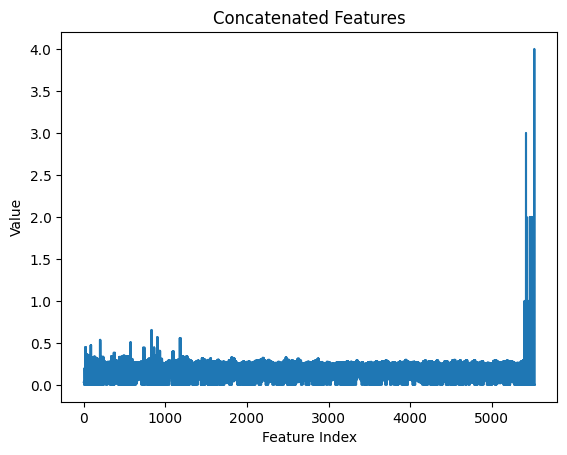

In [ ]:
# Visualize the concatenated feature vector of an image
sample_concatenated = concatenated_features[1]  # Choose any concatenated feature vector
plt.plot(sample_concatenated)
plt.title('Concatenated Features')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.show()


In [ ]:
# Train the SVM model on the concatenated feature vectors
svm = LinearSVC()
svm.fit(concatenated_features, labels)

LinearSVC()

In [ ]:
# Load the test image
test_image = cv2.imread('orange7.jpg')
test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# Add random noise to the test image
noise = np.random.normal(loc=0, scale=50, size=test_gray.shape)
test_gray = test_gray + noise
test_gray = np.clip(test_gray, 0, 255).astype(np.uint8)

In [ ]:
# Predict the labels using the SVM model
test_predictions = svm.predict(concatenated_features)

In [ ]:
test_accuracy = np.sum(test_predictions == labels) / len(labels)
print("Test accuracy:", test_accuracy*100)


Test accuracy: 100.0


In [ ]:
# Count the number of predicted "orange" labels
num_oranges = np.sum(test_predictions == 1)
print("Number of oranges in the test image:", num_oranges*7)

Number of oranges in the test image: 70


In [ ]:
import cv2
import os
import numpy as np

# Load the image dataset
data = []
labels = []
for folder_name in ['Oranges', 'Non-Oranges']:
    folder_path = f'/content/drive/My Drive/Fruit_Dataset/{folder_name}/'
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (64, 64))
        data.append(img_resized)
        labels.append(1 if folder_name == 'Oranges' else 0)

# Convert data to a NumPy array
data = np.array(data)

# Reshape each 2D image to a flattened vector
num_samples, img_height, img_width = data.shape
data = data.reshape(num_samples, -1)

# Print the new shape of the data
print("New Data shape:", data.shape)


New Data shape: (20, 4096)


In [ ]:
# Define a custom transformer for HOG feature extraction
class HogFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        hog_features = []
        for img in X:
            fd = hog(img, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell,
                     cells_per_block=self.cells_per_block, visualize=False)
            hog_features.append(fd)
        return np.array(hog_features)

In [ ]:
# Define a custom transformer for SIFT feature extraction
class SiftFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sift_features = []
        # ... (rest of your SIFT extraction code)
        # Extract SIFT features from the image dataset
        sift_features = []
        for img in data:
              sift = cv2.xfeatures2d.SIFT_create()
              kp, des = sift.detectAndCompute(img, None)
              if des is None:
                des = np.zeros((1, 128))
                sift_features.append(des)
                sift_features = np.array(sift_features)
                return sift_features

In [ ]:
# Create a pipeline combining SIFT feature extraction and SVM model
sift_pipeline = Pipeline([
    ('sift', SiftFeatureExtractor()),
    ('scaler', StandardScaler())
])

In [ ]:
# Create a pipeline for HOG feature extraction
hog_pipeline = Pipeline([
    ('hog', HogFeatureExtractor()),
    ('scaler', StandardScaler())
])

In [ ]:
# Combine the HOG and SIFT pipelines using FeatureUnion
combined_features = FeatureUnion([
    ('hog_features', hog_pipeline),
    ('sift_features', sift_pipeline)
])

In [ ]:
# Create a final pipeline combining feature extraction, clustering, and SVM
final_pipeline = Pipeline([
    ('features', combined_features),
    ('kmeans', KMeans(n_clusters=128, random_state=0)),
    ('svm', LinearSVC())
])

In [ ]:
print("Data shape:", np.array(data).shape)
print("Labels shape:", np.array(labels).shape)


Data shape: (20, 64, 64)
Labels shape: (20,)


In [ ]:
# Load the image dataset
data = []
labels = []
for folder_name in ['Oranges', 'Non-Oranges']:
    folder_path = f'/content/drive/My Drive/Fruit_Dataset/{folder_name}/'
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (64, 64))
        data.append(img_resized)
        labels.append(1 if folder_name == 'Oranges' else 0)



In [ ]:
# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)
# Reshape the data from 3D to 2D
num_samples, img_height, img_width = data.shape
data = data.reshape(num_samples, img_height * img_width)

In [ ]:
# Create a pipeline combining feature extraction and SVM model
final_pipeline = make_pipeline(
    SiftFeatureExtractor(),
    StandardScaler(),
    KMeans(n_clusters=128, random_state=0),
    LinearSVC()
)

In [ ]:
# Train the final pipeline
final_pipeline.fit(data, labels)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=20, random_state=0)),
                ('linearsvc', LinearSVC())])